# ADFA-LD - Model Evaluation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statistics
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re

Using TensorFlow backend.


In [3]:
import glob
import math
from collections import Counter
import csv

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# returns a dictionary of n-grams frequency for any list
def ngrams_freq(listname, n):
    counts = dict()
    # make n-grams as string iteratively
    grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
    for gram in grams:
        if gram not in counts:
            counts[gram] = 1
        else:
            counts[gram] += 1
    return counts

# returns the values of features for any list
def feature_freq(listname,n,features):
	counts = dict()
	# make n-grams as string iteratively
	grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
	for gram in grams:
		counts[gram] = 0
	for gram in grams:
		if gram in features:
			counts[gram] += 1
	return counts

# values of n for finding n-grams
n_values = [1]

# Base address for attack data files
add = "ADFA-LD/ADFA-LD/Attack_Data_Master/"
# list of attacks
attack = ['Adduser','Hydra_FTP','Hydra_SSH','Java_Meterpreter','Meterpreter','Web_Shell']

# initializing dictionary for n-grams from all files
traindict = {}

Attack_list_new = []
print("Generating Training Data ..................................")
for term in attack:
	print("	Training data from " + term)
	globals()['%s_list' % term] = []
	in_address = add+term
	k = 1
	# finding list of data from all files
	for i in range (1,11):
		read_files = glob.glob(in_address+"_"+str(i)+"/*.txt")
		for f in read_files:
			with open(f, "r") as infile:
				globals()['%s_list_array' % term+str(k)] = ALine =infile.read()
				#ALine = ALine[:820]                
				Attack_list_new.append(term +','+ str(ALine))
				globals()['%s_list' % term].extend(globals()['%s_list_array' % term+str(k)])
				k += 1
	# number of lists for distinct files
	globals()['%s_size' % term] = k-1
	# combined list of all files
	listname = globals()['%s_list' % term]
	# finding n-grams and extracting top 30%
	for n in n_values:
		#print("		Extracting top 30% "+str(n)+"-grams from "+term+".......................")
		dictname = ngrams_freq(listname,n)
		top = math.ceil(0.3*len(dictname))
		dictname = Counter(dictname)
		for k, v in dictname.most_common(top):
			traindict.update({k : v})

# finding training data for Normal file
print("	Training data from Normal")
Normal_list = []
Normal_list_new = []
in_address = "ADFA-LD/ADFA-LD/Training_Data_Master/"
k = 1
read_files = glob.glob(in_address+"/*.txt")
for f in read_files:
	with open(f, "r") as infile:
		globals()['Normal%s_list_array' % str(k)] = Line = infile.read()
		Normal_list_new.append('Normal,'+ str(Line))
		Normal_list.extend(globals()['Normal%s_list_array' % str(k)])
		k += 1

# number of lists for distinct files
Normal_list_size = k-1
# combined list of all files
listname = Normal_list


print("\nnew_train.csv created..............................................\n")


Generating Training Data ..................................
	Training data from Adduser
	Training data from Hydra_FTP
	Training data from Hydra_SSH
	Training data from Java_Meterpreter
	Training data from Meterpreter
	Training data from Web_Shell
	Training data from Normal

new_train.csv created..............................................



In [4]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new
#new_train_list[1]
#Attack_list_new[1]


In [5]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new


with open('new_train.csv', 'w') as f:
    for item in new_train_list:
        f.write("%s\n" % item)       

In [6]:
train = pd.read_csv("./new_train.csv", sep=',',error_bad_lines=False, header=None, names=['Label','CallTrace'])
train.head(5)
train.shape
#train.info()

#train.describe(include = 'all')
train_df = train.copy()
train['Label'] = train['Label'].astype('category')
train['CallTrace'] = train['CallTrace'].astype('category')

train['Label'].value_counts()
#train['CallTrace'].value_counts()

Normal              833
Hydra_SSH           176
Hydra_FTP           162
Java_Meterpreter    124
Web_Shell           118
Adduser              91
Meterpreter          75
Name: Label, dtype: int64

In [7]:
train['Label_Codes'] = train['Label'].cat.codes
train['CallTrace_Codes'] = train['CallTrace'].cat.codes
train['Label_Codes'].value_counts()

5    833
2    176
1    162
3    124
6    118
0     91
4     75
Name: Label_Codes, dtype: int64

In [8]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93


# Multinominal Logistic Regression

In [9]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 2].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 145
Accuracy: 0.54


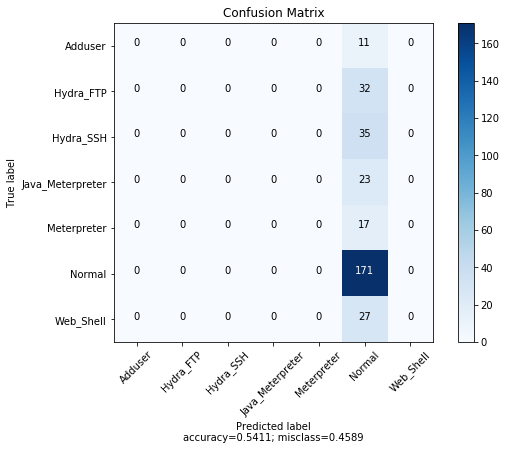

In [10]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

# Logistic Regression Binary Classification

In [11]:
train.loc[train.Label != 'Normal','Label_Binary']= 1
train.loc[train.Label == 'Normal','Label_Binary']= 0
train['Label_Binary'].value_counts()
#train.head()

0.0    833
1.0    746
Name: Label_Binary, dtype: int64

In [12]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes,Label_Binary
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407,0.0
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239,0.0
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286,0.0
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465,0.0
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93,0.0


In [13]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 4].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 156
Accuracy: 0.51


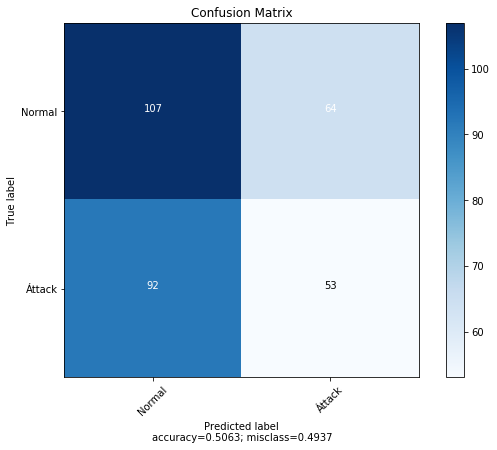

In [14]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [15]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58       199
         1.0       0.37      0.45      0.40       117

   micro avg       0.51      0.51      0.51       316
   macro avg       0.50      0.50      0.49       316
weighted avg       0.53      0.51      0.51       316



# OneHotEncoding for LogisticRegression

In [16]:
# Split into predictor and response dataframes.
train_df_enc = train_df.copy()
X_df = train_df_enc.drop('Label', axis=1)
y = train_df_enc['Label']

X_df.shape,y.shape

((1579, 1), (1579,))

In [17]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [18]:
train_df.head()

,Label,CallTrace
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [19]:
# Map response variable to integers 0,1.
y = pd.Series(np.where(y.values != 'Normal',1,0), y.index)
y.value_counts()

0    833
1    746
dtype: int64

In [20]:
# Label Encode instead of dummy variables

mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = train.drop('Label', axis=1)
label_df = train.drop('Label_Binary', axis=1)
label_df = train.drop('Label_Codes', axis=1)
label_df['CallTrace'] = label_df['CallTrace_Codes']
label_df = X_df.copy()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [21]:
label_df.head()

,CallTrace
0,1407
1,1239
2,1286
3,1465
4,93


In [22]:
from sklearn.preprocessing import OneHotEncoder


onehot_encoder = OneHotEncoder()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = onehot_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(onehot_encoder.classes_, range(1, len(onehot_encoder.classes_)+1))))

In [23]:
 label_df[col].head()

0    1407
1    1239
2    1286
3    1465
4      93
Name: CallTrace, dtype: int32

In [24]:
X_train, X_test, y_train, y_test = train_test_split(label_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [25]:
clf = LogisticRegression()
model_mix = clf.fit(X_train, y_train)
# y_pred = model_norm.predict(X_test)
print("Model accuracy is", model_mix.score(X_test, y_test))

Model accuracy is 0.5569620253164557


In [26]:
model_mix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
# logit_roc_auc = roc_auc_score(y_test, model_norm.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, model_norm.predict_proba(X_test)[:,1])

classes = model_mix.predict(X_test)
probs = model_mix.predict_proba(X_test)
preds = probs[:,1]
#preds

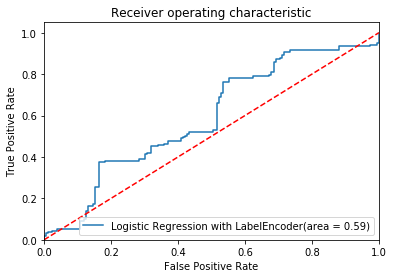

In [28]:
labelfpr, labeltpr, labelthreshold = metrics.roc_curve(y_test, preds)
label_roc_auc = metrics.auc(labelfpr, labeltpr)

plt.figure()
plt.plot(labelfpr, labeltpr, label='Logistic Regression with LabelEncoder(area = %0.2f)' % label_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

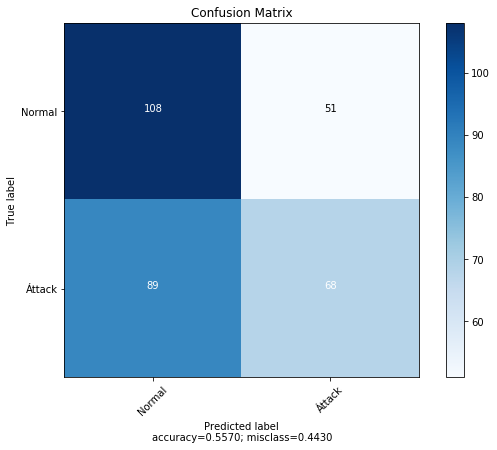

In [29]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [31]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       197
           1       0.43      0.57      0.49       119

   micro avg       0.56      0.56      0.56       316
   macro avg       0.56      0.56      0.55       316
weighted avg       0.59      0.56      0.56       316



# RandomForest Classification

In [32]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
clf = RandomForestClassifier(n_jobs=-1)
model_rf = clf.fit(X_train, y_train)
print('Model accuracy is',model_rf.score(X_test, y_test))

Model accuracy is 0.8069620253164557


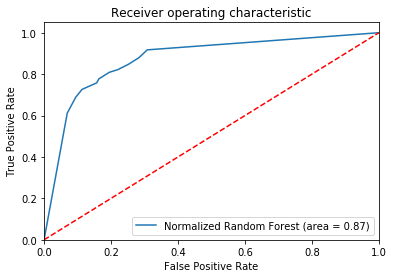

In [34]:
probs = model_rf.predict_proba(X_test)
preds = probs[:,1]
rffpr, rftpr, rfthreshold = metrics.roc_curve(y_test, preds)
rf_roc_auc = metrics.auc(rffpr, rftpr)

plt.figure()
plt.plot(rffpr, rftpr, label='Normalized Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

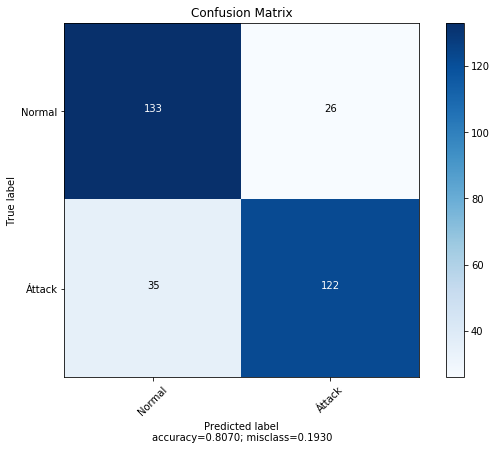

In [35]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
classes = model_rf.predict(X_test)
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [36]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       168
           1       0.78      0.82      0.80       148

   micro avg       0.81      0.81      0.81       316
   macro avg       0.81      0.81      0.81       316
weighted avg       0.81      0.81      0.81       316



# Train Data with ngrams

In [37]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.1, 0.9],
    n_features=20, n_samples=1000, random_state=10
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.5
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.531646
recall,0.579618
precision,0.526012
roc_auc_score,0.531947


In [38]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

# load the dataset
#data = open('data/corpus').read()
#labels, texts = [], []
#for i, line in enumerate(data.split("\n")):
#    content = line.split()
#    labels.append(content[0])
#    texts.append(" ".join(content[1:]))

# create a dataframe using texts and lables
#trainDF = pandas.DataFrame()
#trainDF['text'] = texts
#trainDF['label'] = labels

In [39]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [40]:
# create a dataframe using texts and lables
trainDF = train_df.copy()

trainDF['CallTrace_T'] = trainDF.CallTrace.str.split(' ').str.join(',').astype(str)
#X_df = trainDF.drop('Label', axis=1)
X_df = trainDF.drop(['Label', 'CallTrace'], axis=1)
y = trainDF['Label']

# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_df, y)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

X_df.head()
#list(encoder.classes_)
#le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
#print(le_name_mapping)

,CallTrace_T
0,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


In [41]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((1184, 1), (395, 1), (1184,), (395,))

In [42]:
trainDF.head()

,Label,CallTrace,CallTrace_T
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


## Feature Engineering - 1n, 2n, 3n-grams


In [43]:
trainDF.head()

,Label,CallTrace,CallTrace_T
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


In [44]:
train_1n = pd.read_csv("./train_1n.csv")
train_1n.columns
train_1n_bkp = train_1n.copy()
train_1n.head()

,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,221,33,180,45,196,120,7,220,42,63,11,1,252,201,243,199,308,122,118,219
0,Adduser,193,75,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adduser,0,110,139,0,0,286,0,55,0,64,0,50,0,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adduser,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adduser,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adduser,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
train_1n.columns

Index(['Label', '168', '265', '3', '54', '162', '142', '309', '146', '114',
       '175', '43', '104', '5', '78', '102', '13', '6', '240', '4', '192',
       '195', '91', '85', '125', '197', '140', '19', '174', '301', '221', '33',
       '180', '45', '196', '120', '7', '220', '42', '63', '11', '1', '252',
       '201', '243', '199', '308', '122', '118', '219'],
      dtype='object')

##  Modelling Logistic Regression - 1n-grams

In [46]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test

#y = train_1n.iloc[:, 0].values
#train_1n_no_y = train_1n.drop('Label', axis=1)
#X = train_1n_no_y.iloc[:, :].values
y = train_1n.iloc[:, 0]
train_1n_no_y = train_1n.drop('Label', axis=1)
X = train_1n_no_y.iloc[:, :]


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)


In [47]:
X_test_bkp = X_test

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X), type(y)

((1070, 49),
 (268, 49),
 (1070,),
 (268,),
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [49]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))


Misclassified samples: 72
Accuracy: 0.73


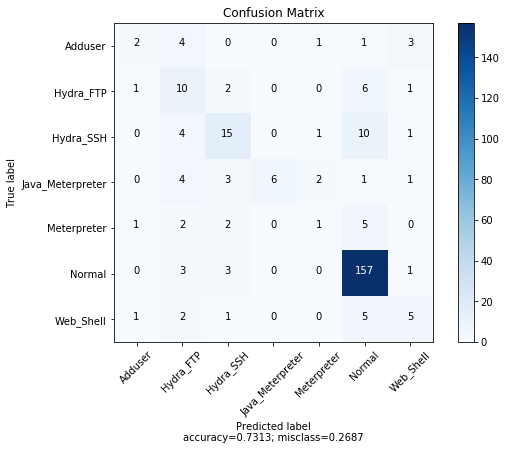

In [50]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

In [51]:
y_pred.shape, y_test.shape, type(y_test)

((268,), (268,), pandas.core.series.Series)

In [52]:
# Merge predicted results into original dataframe
# y_test['preds'] = y_pred
# df_out = pd.merge(train_1n, y_test[['preds']], how = 'left', right_index = True)

In [53]:
train_1n.index

RangeIndex(start=0, stop=1338, step=1)

In [54]:
train_2n = pd.read_csv("./train_2n.csv")
train_2n.columns
train_2n_bkp = train_2n.copy()
train_2n.head() 

,Label,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,54 3,146 168,175 142,168 43,114 114,146 265,265 146,142 175,265 43,3 146,104 3,309 3,3 104,104 142,5 5,3 175,43 265,5 3,43 3,3 43,142 104,192 192,102 168,142 119,265 104,197 192,146 146,119 142,168 102,175 3,192 6,43 43,104 265,3 197,33 5,125 125,3 5,6 33,265 175,175 104,175 265,175 146,19 19,265 102,119 265,104 175,146 175,91 5,175 119,146 104,3 309,3 6,5 197,265 119,91 3,5 6,119 3,3 91,78 78,142 78,78 142,78 102,78 13,102 102,240 240,13 13,13 78,13 4,102 78,4 78,240 13,102 142,309 102,78 146,102 309,146 78,85 195,142 102,102 27,6 125,265 240,195 85,4 240,4 4,240 4,13 240,5 102,6 5,102 5,6 91,5 192,13 265,102 6,102 13,195 5,192 3,102 265,78 240,6 78,6 142,102 195,4 13,240 78,195 78,142 6,78 4,27 85,78 6,10 102,27 102,102 85,85 85,6 102,4 265,91 91,125 91,13 102,27 5,5 309,309 5,196 102,85 102,125 3,221 221,5 91,91 195,91 6,195 102,168 78,27 309,78 168,6 6,78 195,309 27,196 196,195 175,195 195,195 3,3 195,3 192,192 5,195 196,5 140,5 195,175 5,6 27,175 195,27 174,7 7,142 195,309 85,102 146,265 4,192 125,6 3,195 142,265 13,3 78,146 102,196 265,265 10,240 265,125 195,125 5,197 3,5 33,78 3,309 195,102 196,102 10,85 265,85 196,125 268,45 45,140 91,142 4,197 5,5 27,140 197,85 309,13 142,195 265,27 27,192 140,4 142,268 5,142 13,6 195,6 196,192 33,6 309,10 309,85 10,78 265,195 6,221 3,174 6,5 13,102 221,104 104,3 13,199 5,174 27,4 3,6 192,13 199,3 4,33 192,140 27,265 78,102 3,3 102,6 265,91 102,3 221,27 221,265 5,221 27,33 6,102 91,13 5,265 54,6 199,195 340,43 195,27 6,5 125,199 201,91 142,340 3,63 63,6 168,140 78,78 140,78 196,196 78,140 3,78 125,146 163,125 78,163 146,219 219,78 192,78 5,3 140,192 78,5 78,140 140,195 140,196 195,120 240,240 102,125 240,102 240,33 33,33 195,104 146,3 125,265 340,78 33,78 120,340 168,265 195,119 146,192 240,3 19,19 3,168 340,3 33,340 265,33 3,175 54,168 195,33 4,119 175,175 174,301 301,220 301,301 220,195 33,221 301,301 300,4 168,301 221,33 13,196 33,195 91,13 33,168 4,301 6,300 301,6 301,102 192,78 104,168 91,7 142,168 45,196 5,33 196,196 91,5 196,197 91,19 168,142 7,195 168,91 45,102 45,91 192,168 19,301 295,192 168,104 13,45 78,192 91,295 301,54 265,104 91,168 192,91 196,13 196,220 220,197 197,45 192,197 6,180 180,240 196,3 45,45 3,5 221,120 6,63 6,6 221,42 120,54 140,1 1,120 114,221 197,140 4,174 175,11 45,45 33,140 6,221 6,5 220,196 240,4 6,120 175,243 125,42 221,4 140,192 243,252 252,5 54,168 42,175 120,220 5,45 5,6 45,221 63,5 4,221 168,308 3,4 7,7 3,45 175,7 308,125 192,168 54,168 240,4 5,220 6,7 175,45 195,195 120,120 3,6 4,265 221,118 6,311 240,221 265,4 175,175 4,45 6,6 63,175 7,54 102,175 45,195 4,102 4,13 195,240 3,6 11,3 7,45 91,195 13,197 140,11 11,6 174,3 240,4 221,114 120,220 195,240 174,33 197,258 311,175 191,191 122,197 221,192 4,91 33,5 45,180 125,91 258,6 54,6 175,221 142,125 180,240 168,195 197,6 114,3 120,140 195,4 195,221 220,6 197,6 7,195 220,6 120,5 175,6 42,174 3,221 4,195 201,114 63,265 140,195 45,5 63,221 33,195 42,331 4,162 3,197 195,196 3,3 176,176 162,114 195,7 119,120 7,240 5,175 42,174 7,91 4,13 175,221 102,114 5,192 195,54 175,195 192,256 265,162 195,240 6,168 7,175 162,5 120,3 196,78 180,4 120,120 120,6 240,221 140,114 42,174 11,197 33,5 141,6 13,158 158,78 219,91 78,140 221,201 202,7 174,4 118,174 45,141 141,141 6,199 102,197 220,42 42,168 6,4 102,4 63,309 265,175 6,140 54,63 120,255 255,240 180,197 45,180 240,4 33,265 256,265 309,91 38,91 197,221 174,180 78,19 196,221 5,192 45,6 140,221 240,45 140,45 64,78 175,199 200,268 45,38 5,5 118,160 159,33 78,192 197,4 91,221 120,45 4,195 54,63 221,54 195,195 174,174 195,4 197,221 195,220 221,197 4,42 168,91 174,140 120,200 33,33 125,311 78,4 174,54 5,240 221,45 168,202 199,196 19,1 252,91 240,252 1,240 33,3 42,54 6,4 331,122 268,140 5,196 85,119 174,201 45,122 45,221 42,168 5,125 45,174 201,221 199,6 10,42 54,168 

In [55]:
train_3n = pd.read_csv("./train_3n.csv")
train_3n.columns
train_3n_bkp = train_3n.copy()
train_3n.head() 

Label  168 168 168  54 54 54  162 162 162  168 265 168  265 168 168  \
0  Adduser          101         0            0           31           34   
1  Adduser            0         0            0            0            0   
2  Adduser           49         0            0           25           26   
3  Adduser            0       431            0            0            0   
4  Adduser          132         0            0           63           68   

   168 168 265  168 3 168  168 168 3  3 168 168  54 309 54  54 54 309  \
0           31          0          0          0          0          0   
1            0          0          0          0          0          0   
2           25         22         23         21          0          0   
3            0          0          0          0        137        128   
4           60         33         42         36          0          0   

   265 168 265  309 54 54  168 265 265  265 265 168  162 114 162  114 162 162  \
0           12          0           14           14            0            0   
1            0          0            0            0            0            0   
2           12          0           11           14            0            0   
3            0        124            0            0            0            0   
4           32          0           32           31            0            0   

   162 162 114  3 168 265  168 265 3  265 3 168  3 265 168  265 168 3  \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0         11         14         15         12         14   
3            0          0          0          0          0          0   
4            0         24         22         16         25         19   

   168 3 265  265 265 265  3 168 3  3 3 168  168 3 3  3 3 3  265 3 265  \
0          0            9        0        0        0      0          0   
1          0            8        0        0        0     18          3   
2         15            8        9        9        7      2          9   
3          0            0        0        0        0      0          0   
4         18           25        9       18       18      7         17   

   265 265 3  174 174 174  265 3 3  3 265 3  3 265 265  309 54 309  3 54 54  \
0          0            0        0        0          0           0        0   
1          4            0        5        5          2           0        0   
2          5            0        5        7          7           0        0   
3          0            0        0        0          0          37       37   
4         13            0       13       11         12           0        0   

   3 3 265  142 142 142  54 309 309  114 162 114  54 3 54  114 114 162  \
0        0            0           0            0        0            0   
1        5           60           0            0        0            0   
2        2            0           0            0        0            0   
3        0            0          26            0       38            0   
4       13            0           0            0        0            0   

   309 309 54  54 54 3  162 114 114  309 3 54  142 142 3  168 146 168  \
0           0        0            0         0          0            0   
1           0        0            0         0         14            0   
2           0        0            0         0          0            0   
3          24       33            0         9          0            0   
4           0        0            0         0          0            0   

   54 309 3  265 142 142  175 175 175  142 142 265  43 168 168  3 142 142  \
0         0            0            0            0           0          0   
1         0           14            7           19           0         14   
2         0            0            0            0          12          0   
3         8            0            0            0           0         

In [56]:
train_1n.shape, train_2n.shape, train_3n.shape

((1338, 50), (1338, 800), (1338, 4148))

In [70]:
train_1n_30 = train_1n.iloc[:, 0:30]
train_2n_30 = train_2n.iloc[:, 0:30]
train_3n_30 = train_3n.iloc[:, 0:30]

# Modelling Logistic Regression/SVM/RandomForrest - 1n-grams + 2n-grams + 3n-grams

In [71]:
frames=[train_1n_30, train_2n_30, train_3n_30]
result=pd.concat(frames, axis=1)
result.shape

(1338, 90)

In [72]:
result.head()

,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,Label,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,Label,168 168 168,54 54 54,162 162 162,168 265 168,265 168 168,168 168 265,168 3 168,168 168 3,3 168 168,54 309 54,54 54 309,265 168 265,309 54 54,168 265 265,265 265 168,162 114 162,114 162 162,162 162 114,3 168 265,168 265 3,265 3 168,3 265 168,265 168 3,168 3 265,265 265 265,3 168 3,3 3 168,168 3 3,3 3 3
0,Adduser,193,75,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adduser,138,0,48,0,47,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adduser,101,0,0,31,34,31,0,0,0,0,0,12,0,14,14,0,0,0,0,0,0,0,0,0,9,0,0,0,0
1,Adduser,0,110,139,0,0,286,0,55,0,64,0,50,0,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,0,Adduser,0,0,0,0,0,0,0,24,45,17,20,0,0,0,0,126,32,38,38,39,0,0,0,0,0,25,14,20,17,Adduser,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,18
2,Adduser,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,Adduser,110,0,60,0,55,48,52,28,16,31,32,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,Adduser,49,0,0,25,26,25,22,23,21,0,0,12,0,11,14,0,0,0,11,14,15,12,14,15,8,9,9,7,2
3,Adduser,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,Adduser,0,594,0,0,0,0,0,0,1,0,0,172,165,0,0,0,0,0,0,0,48,0,26,0,0,0,0,0,0,Adduser,0,431,0,0,0,0,0,0,0,137,128,0,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adduser,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Adduser,236,0,117,0,119,69,71,69,38,46,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adduser,132,0,0,63,68,60,33,42,36,0,0,32,0,32,31,0,0,0,24,22,16,25,19,18,25,9,18,18,7


In [73]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 90 columns):
Label          1338 non-null object
168            1338 non-null int64
265            1338 non-null int64
3              1338 non-null int64
54             1338 non-null int64
162            1338 non-null int64
142            1338 non-null int64
309            1338 non-null int64
146            1338 non-null int64
114            1338 non-null int64
175            1338 non-null int64
43             1338 non-null int64
104            1338 non-null int64
5              1338 non-null int64
78             1338 non-null int64
102            1338 non-null int64
13             1338 non-null int64
6              1338 non-null int64
240            1338 non-null int64
4              1338 non-null int64
192            1338 non-null int64
195            1338 non-null int64
91             1338 non-null int64
85             1338 non-null int64
125            1338 non-null int64
197            13

In [74]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
result = result.loc[:,~result.columns.duplicated()]

y = result.iloc[:, 0].values
result_no_y = result.drop('Label', axis=1)
X = result_no_y.iloc[:, :].values

In [75]:
#result

In [76]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X), type(y)

((1070, 87), (268, 87), (1070,), (268,), numpy.ndarray, numpy.ndarray)

In [77]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
#classifier = SVC(kernel = 'linear', random_state = 0)
#classifier = SVC(kernel = 'rbf', random_state = 0)
clf = RandomForestClassifier(n_jobs=-1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
#y_pred

Misclassified samples: 73
Accuracy: 0.73


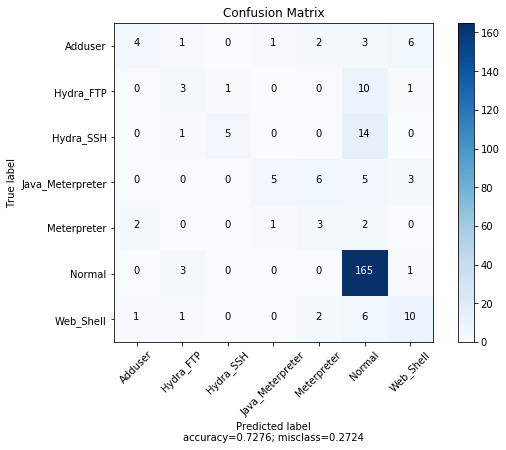

In [78]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

## Applying 10-Fold cross-validation 

In [79]:
from sklearn.model_selection import cross_val_score
import numpy as np

print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))

0.8121539825388545


# Comparing Different Models BinaryCalssification - 1n-grams + 2n-grams + 3n-grams

In [80]:
# Compare Algorithms
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load dataset
Y = result.iloc[:, 0].values
result_no_y = result.drop('Label', axis=1)
X = result_no_y.iloc[:, :].values
#X = array[:,0:8]
#Y = array[:,8]

# Prepare configuration for cross validation test harness
seed = 7



In [81]:
# Prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RandomForest', RandomForestClassifier()))



In [82]:
# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)



LR: 0.629806 (0.349178)
LDA: 0.626826 (0.370299)
KNN: 0.602828 (0.329431)
CART: 0.616250 (0.311622)
NB: 0.616266 (0.331033)
SVM: 0.625373 (0.459750)
RandomForest: 0.675362 (0.364782)


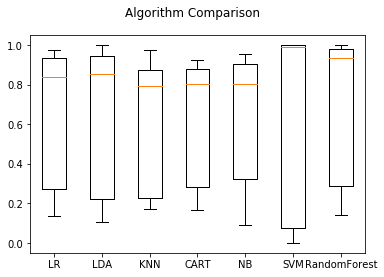

In [83]:
# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Random Forest & Logistic Regression gave best accuracy so far

# Random Forest Model Parameter Tuning

In [84]:
train_1n_30 = train_1n.iloc[:, 0:30]
train_2n_30 = train_2n.iloc[:, 0:30]
train_3n_30 = train_3n.iloc[:, 0:30]

In [85]:
train_1n_30.shape

(1338, 30)

In [86]:
train_2n_30.shape

(1338, 30)

In [87]:
train_3n_30.shape

(1338, 30)

In [88]:
#frames = [train_1n, train_2n, train_3n]
frames = [train_1n_30, train_2n_30, train_3n_30]
result = pd.concat(frames, axis=1)

result = result.loc[:,~result.columns.duplicated()]

result.loc[result.Label != 'Normal','Label']= 1
result.loc[result.Label == 'Normal','Label']= 0
result.head()
#result['Label_Binary'].value_counts()

# Extract features and labels
labels = result['Label']
features = result.drop('Label', axis = 1)
#features.head(5)
#labels.head(5)


# One Hot Encoding
#features = pd.get_dummies(result)
#features.head(5)


#from sklearn import preprocessing

#le = preprocessing.LabelEncoder()
#features['Label_Normal'] = le.fit_transform(features['Label_Normal'])

    
#cols_drop = [ 'Label_Meterpreter', 'Label_Web_Shell', 'Label_Adduser',
#       'Label_Hydra_FTP', 'Label_Hydra_SSH', 'Label_Java_Meterpreter', 'Label_Normal']

# Extract features and labels
#labels = features['Label_Normal']
#labels['Label_Normal'].astype(object).astype(int)
#labels = labels.loc[:,~labels.columns.duplicated()]
#features = features.drop(cols_drop, axis = 1)
#features.head(5)
#labels.head(5)


In [89]:
# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [90]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1003, 87)
Training Labels Shape: (1003,)
Testing Features Shape: (335, 87)
Testing Labels Shape: (335,)


### Examine the Default Random Forest to Determine Parameters

In [91]:
# Reference : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

rf = RandomForestClassifier(random_state=42) 

#Look at parameters used by  our current forest
pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Random Search with Cross Validation

In [92]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [93]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_labels);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


## Best Parameters Identified 

In [94]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [95]:
 #rf_random.cv_results_

## Evaluate Random Search
To determine if random search yielded a better model, we compare the base model with the best random search model.

In [96]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print('Accuracy: {:.2f}'.format(accuracy))
   

#### Evaluate the Default Model

In [97]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)


Accuracy: 0.96


#### Evaluate the Best Random Search Model

In [98]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

Accuracy: 0.97


### Grid Search
We can now perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [99]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [100]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.1min finished


In [101]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

#### Evaluate the Best Model from Grid Search

In [102]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Accuracy: 0.91


## Final Model

In [103]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, test_features, test_labels)

Final Model Parameters:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Accuracy: 0.91


## Deep Autoencoder Model

In [104]:
# https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
# https://www.curiousily.com/posts/credit-card-fraud-detection-using-autoencoders-in-keras/


In [107]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Attack"]

In [197]:
#result = result.loc[:,~result.columns.duplicated()]

#result.loc[result.Label != 'Normal','Label']= 1
#result.loc[result.Label == 'Normal','Label']= 0
result.head()



,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,168 168 168,54 54 54,162 162 162,168 265 168,265 168 168,168 168 265,168 3 168,168 168 3,3 168 168,54 309 54,54 54 309,265 168 265,309 54 54,168 265 265,265 265 168,162 114 162,114 162 162,162 162 114,3 168 265,168 265 3,265 3 168,3 265 168,265 168 3,168 3 265,265 265 265,3 168 3,3 3 168,168 3 3,3 3 3
0,1,193,75,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138,0,48,0,47,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,0,0,31,34,31,0,0,0,0,0,12,0,14,14,0,0,0,0,0,0,0,0,0,9,0,0,0,0
1,1,0,110,139,0,0,286,0,55,0,64,0,50,0,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,45,17,20,0,0,0,0,126,32,38,38,39,0,0,0,0,0,25,14,20,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,18
2,1,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,110,0,60,0,55,48,52,28,16,31,32,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,49,0,0,25,26,25,22,23,21,0,0,12,0,11,14,0,0,0,11,14,15,12,14,15,8,9,9,7,2
3,1,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,594,0,0,0,0,0,0,1,0,0,172,165,0,0,0,0,0,0,0,48,0,26,0,0,0,0,0,0,0,431,0,0,0,0,0,0,0,137,128,0,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,236,0,117,0,119,69,71,69,38,46,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132,0,0,63,68,60,33,42,36,0,0,32,0,32,31,0,0,0,24,22,16,25,19,18,25,9,18,18,7


In [198]:
attack = result[result.Label == 1]
normal = result[result.Label == 0]

In [199]:
attack.shape

(505, 88)

In [200]:
normal.shape

(833, 88)

In [201]:
X_train, X_test = train_test_split(result, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Label == 0]
X_train = X_train.drop(['Label'], axis=1)

y_test = X_test['Label']
X_test = X_test.drop(['Label'], axis=1)

X_train = X_train.values
X_test = X_test.values


In [202]:
X_train.shape

(662, 87)

Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [203]:
input_dim = X_train.shape[1]
encoding_dim = 87

In [204]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 87)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 87)                7656      
_________________________________________________________________
dense_23 (Dense)             (None, 43)                3784      
_________________________________________________________________
dense_24 (Dense)             (None, 43)                1892      
_________________________________________________________________
dense_25 (Dense)             (None, 87)                3828      
Total params: 17,160
Trainable params: 17,160
Non-trainable params: 0
_________________________________________________________________


In [205]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 662 samples, validate on 268 samples
Epoch 1/100
662/662 [==============================] - 1s 1ms/step - loss: 1772.3296 - acc: 0.1269 - val_loss: 1455.3620 - val_acc: 0.3246
Epoch 2/100
662/662 [==============================] - 0s 88us/step - loss: 1763.8562 - acc: 0.4305 - val_loss: 1448.1460 - val_acc: 0.3657
Epoch 3/100
662/662 [==============================] - 0s 127us/step - loss: 1755.7174 - acc: 0.3927 - val_loss: 1440.5295 - val_acc: 0.3396
Epoch 4/100
662/662 [==============================] - 0s 118us/step - loss: 1747.7508 - acc: 0.3988 - val_loss: 1433.7527 - val_acc: 0.3246
Epoch 5/100
662/662 [==============================] - 0s 93us/step - loss: 1741.0570 - acc: 0.3973 - val_loss: 1427.6122 - val_acc: 0.3358
Epoch 6/100
662/662 [==============================] - 0s 78us/step - loss: 1735.1214 - acc: 0.4003 - val_loss: 1422.5346 - val_acc: 0.3396
Epoch 7/100
662/662 [==============================] - 0s 69us/step - loss: 1729.6751 - acc: 0.4018 - val_loss: 1

662/662 [==============================] - 0s 108us/step - loss: 1583.1369 - acc: 0.6073 - val_loss: 1303.9331 - val_acc: 0.5448
Epoch 59/100
662/662 [==============================] - 0s 99us/step - loss: 1581.1843 - acc: 0.5937 - val_loss: 1301.6671 - val_acc: 0.5522
Epoch 60/100
662/662 [==============================] - 0s 147us/step - loss: 1579.1445 - acc: 0.6088 - val_loss: 1300.5726 - val_acc: 0.5522
Epoch 61/100
662/662 [==============================] - 0s 211us/step - loss: 1577.1745 - acc: 0.6088 - val_loss: 1296.6505 - val_acc: 0.5560
Epoch 62/100
662/662 [==============================] - 0s 423us/step - loss: 1575.0608 - acc: 0.6118 - val_loss: 1297.1320 - val_acc: 0.5522
Epoch 63/100
662/662 [==============================] - 0s 646us/step - loss: 1572.8778 - acc: 0.6073 - val_loss: 1295.8903 - val_acc: 0.5672
Epoch 64/100
662/662 [==============================] - 0s 268us/step - loss: 1570.8345 - acc: 0.6133 - val_loss: 1291.9387 - val_acc: 0.5485
Epoch 65/100
662/662

In [206]:
# Evaluation

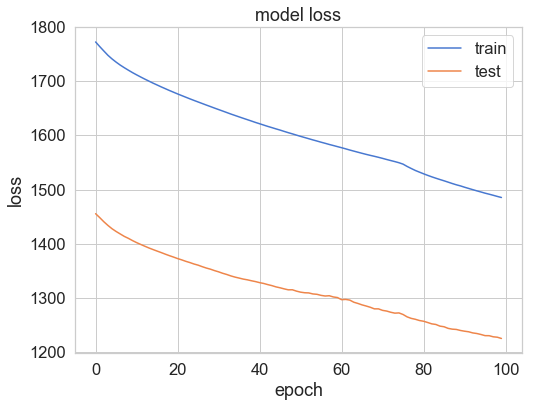

In [207]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [208]:
predictions = autoencoder.predict(X_test)

In [209]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [210]:
error_df.describe()

,reconstruction_error,true_class
count,268.000000,268.000000
mean,1224.792313,0.361940
std,4384.926123,0.481461
min,0.156854,0.000000
25%,7.425676,0.000000
50%,49.709823,0.000000
75%,484.742878,1.000000
max,45076.974703,1.000000


In [211]:
# Reconstruction error without Attack

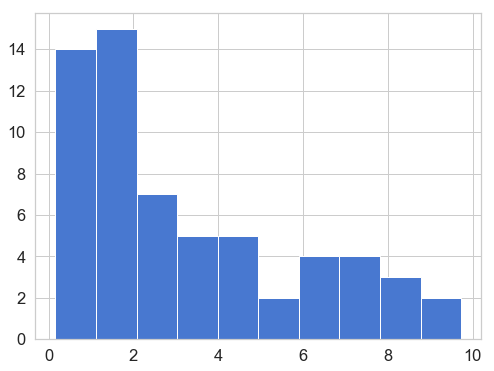

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

##  Reconstruction error with Attack

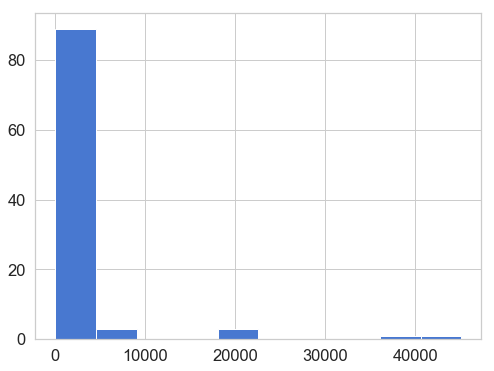

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [214]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

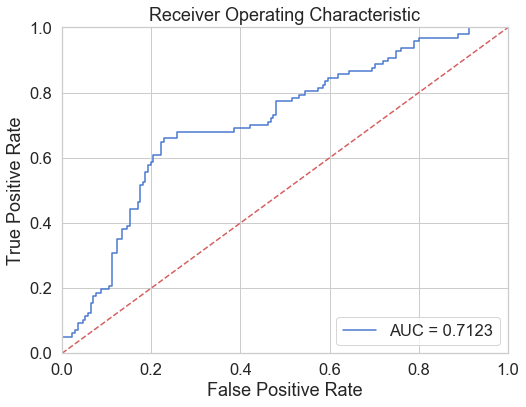

In [215]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

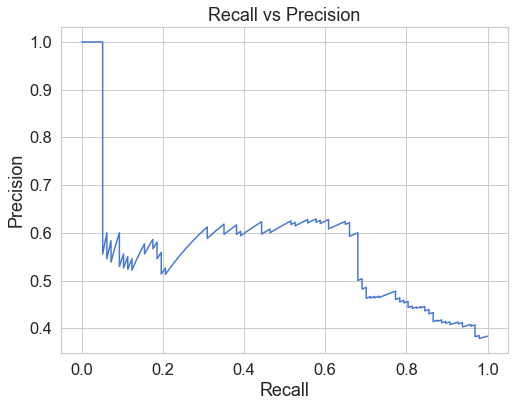

In [216]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

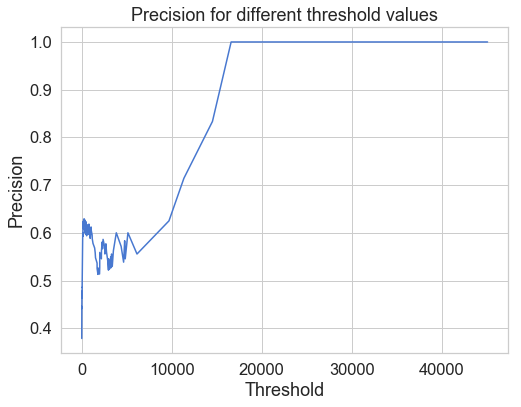

In [217]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

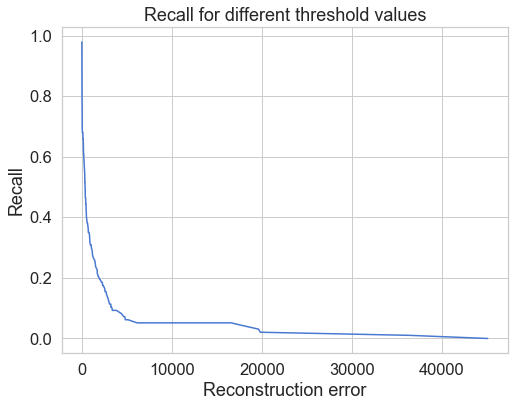

In [218]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

Prediction
Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen system call sequence is normal or attack, we'll calculate the reconstruction error from the systemcall data itself. If the error is larger than a predefined threshold, we'll mark it as a attack (since our model should have a low error on normal transactions). Let's pick that value:

In [219]:
threshold = 20

And see how well we're dividing the two types of transactions:

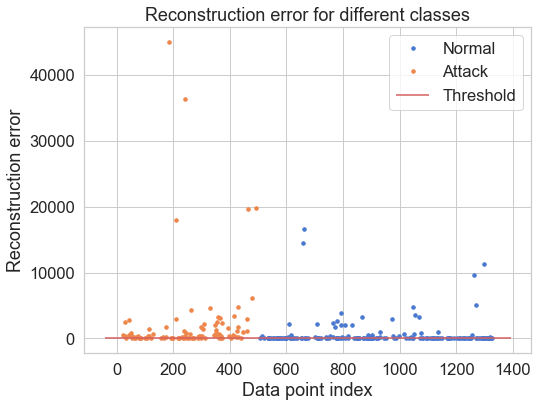

In [220]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

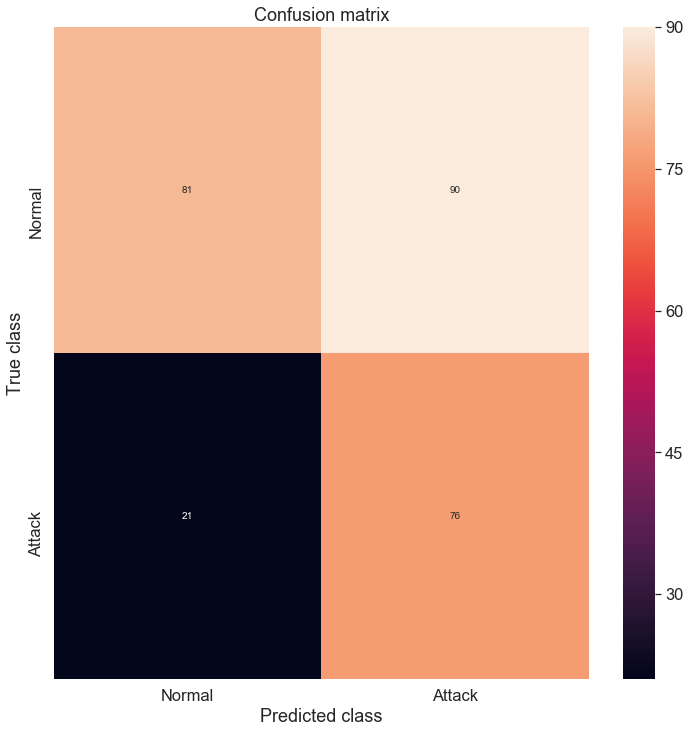

In [221]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the attack cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as Attack is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.



Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what normal system call looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal systemcalls) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?



References

Building Autoencoders in Keras
Stanford tutorial on Autoencoders
Stacked Autoencoders in TensorFlow

# LSTM Autoencoder Classifier Model

In [185]:
# LsTM autoencoder - https://machinelearningmastery.com/lstm-autoencoders/
# LSTM Autoencoder - https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

### Prepare data for LSTM models



LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [142]:
result.head()

,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,168 168 168,54 54 54,162 162 162,168 265 168,265 168 168,168 168 265,168 3 168,168 168 3,3 168 168,54 309 54,54 54 309,265 168 265,309 54 54,168 265 265,265 265 168,162 114 162,114 162 162,162 162 114,3 168 265,168 265 3,265 3 168,3 265 168,265 168 3,168 3 265,265 265 265,3 168 3,3 3 168,168 3 3,3 3 3
0,1,193,75,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138,0,48,0,47,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,0,0,31,34,31,0,0,0,0,0,12,0,14,14,0,0,0,0,0,0,0,0,0,9,0,0,0,0
1,1,0,110,139,0,0,286,0,55,0,64,0,50,0,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,45,17,20,0,0,0,0,126,32,38,38,39,0,0,0,0,0,25,14,20,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,18
2,1,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,110,0,60,0,55,48,52,28,16,31,32,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,49,0,0,25,26,25,22,23,21,0,0,12,0,11,14,0,0,0,11,14,15,12,14,15,8,9,9,7,2
3,1,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,594,0,0,0,0,0,0,1,0,0,172,165,0,0,0,0,0,0,0,48,0,26,0,0,0,0,0,0,0,431,0,0,0,0,0,0,0,137,128,0,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,236,0,117,0,119,69,71,69,38,46,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132,0,0,63,68,60,33,42,36,0,0,32,0,32,31,0,0,0,24,22,16,25,19,18,25,9,18,18,7


In [148]:
input_X = result.loc[:, result.columns != 'Label'].values  # converts the df to a numpy array
input_y = result['Label'].values

n_features = input_X.shape[1]  # number of features


In [144]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the temporalize function with lookback=5. For the modeling, we may use a longer lookback.

In [146]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(result.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,168 168 168,54 54 54,162 162 162,168 265 168,265 168 168,168 168 265,168 3 168,168 168 3,3 168 168,54 309 54,54 54 309,265 168 265,309 54 54,168 265 265,265 265 168,162 114 162,114 162 162,162 162 114,3 168 265,168 265 3,265 3 168,3 265 168,265 168 3,168 3 265,265 265 265,3 168 3,3 3 168,168 3 3,3 3 3


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
0,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,110,0,60,0,55,48,52,28,16,31,32,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,49,0,0,25,26,25,22,23,21,0,0,12,0,11,14,0,0,0,11,14,15,12,14,15,8,9,9,7,2
1,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,594,0,0,0,0,0,0,1,0,0,172,165,0,0,0,0,0,0,0,48,0,26,0,0,0,0,0,0,0,431,0,0,0,0,0,0,0,137,128,0,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,236,0,117,0,119,69,71,69,38,46,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132,0,0,63,68,60,33,42,36,0,0,32,0,32,31,0,0,0,24,22,16,25,19,18,25,9,18,18,7
3,227,115,90,1,3,0,0,40,0,0,0,0,0,10,0,0,0,0,4,0,0,0,0,0,0,0,36,0,0,107,0,57,0,54,37,28,30,21,20,15,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,11,0,0,52,0,0,28,27,26,11,14,15,0,0,15,0,17,13,0,0,0,9,9,10,7,4,6,6,5,7,9,6
4,0,0,0,0,325,0,0,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,247,0,0,0,0,0,0,0,0,0,78,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186,0,0,0,0,0,0,0,0,0,0,0,0,62,61,61,0,0,0,0,0,0,0,0,0,0,0


### Divide the data into train, valid, and test

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Attack"]

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [151]:
X_train.shape

(852, 5, 1, 87)

In [152]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [153]:
X_train_y0.shape

(542, 5, 1, 87)

### Reshaping the data


The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [154]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [155]:
n_features

87

Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature.

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

flatten: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of temporalize, meaning X = flatten(temporalize(X)).
scale: This function will scale a 3D array that we created as inputs to the LSTM.

In [156]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [157]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [158]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [159]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [0.169742 0.142066 0.195572 0.156827 0.051661 0.073801 0.055351 0.125461
 0.136531 0.132841 0.       0.       0.175277 0.178967 0.177122 0.178967
 0.114391 0.145756 0.154982 0.180812 0.182657 0.125461 0.051661 0.142066
 0.145756 0.190037 0.04797  0.193727 0.042435 0.156827 0.075646 0.123616
 0.042435 0.119926 0.114391 0.140221 0.105166 0.162362 0.081181 0.079336
 0.       0.       0.       0.       0.073801 0.051661 0.046125 0.
 0.       0.068266 0.208487 0.042435 0.       0.110701 0.       0.077491
 0.       0.154982 0.180812 0.057196 0.042435 0.101476 0.062731 0.094096
 0.107011 0.127306 0.136531 0.       0.       0.114391 0.       0.070111
 0.079336 0.       0.       0.       0.094096 0.090406 0.105166 0.081181
 0.081181 0.092251 0.081181 0.110701 0.086716 0.114391 0.145756]
colwise variance [0.71657521 0.77502008 0.62595825 0.7226379  0.95674079 0.94289293
 0.96003595 0.84403807 0.7931673  0.83475171 0.         0.
 0.67592013 0.70413325 0.69925518 0.67461295 0.81717297

The test succeeded. Now we will _scale_ the validation and test sets.

In [160]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

### LSTM Autoencoder training



First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [161]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 87

epochs = 200
batch = 64
lr = 0.0001

In [162]:
n_features

87

In [166]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 32)             15360     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 87)             2871      
Total params: 29,751
Trainable params: 29,751
Non-trainable params: 0
_________________________________________________________________


As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).

In [168]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Train on 542 samples, validate on 125 samples
Epoch 1/200
 - 4s - loss: 143.0217 - val_loss: 83.8761
Epoch 2/200
 - 0s - loss: 143.0174 - val_loss: 83.8738
Epoch 3/200
 - 0s - loss: 143.0151 - val_loss: 83.8722
Epoch 4/200
 - 0s - loss: 143.0130 - val_loss: 83.8712
Epoch 5/200
 - 0s - loss: 143.0115 - val_loss: 83.8701
Epoch 6/200
 - 0s - loss: 143.0103 - val_loss: 83.8695
Epoch 7/200
 - 0s - loss: 143.0093 - val_loss: 83.8689
Epoch 8/200
 - 0s - loss: 143.0084 - val_loss: 83.8690
Epoch 9/200
 - 0s - loss: 143.0076 - val_loss: 83.8682
Epoch 10/200
 - 0s - loss: 143.0069 - val_loss: 83.8675
Epoch 11/200
 - 0s - loss: 143.0058 - val_loss: 83.8673
Epoch 12/200
 - 0s - loss: 143.0050 - val_loss: 83.8669
Epoch 13/200
 - 0s - loss: 143.0042 - val_loss: 83.8668
Epoch 14/200
 - 0s - loss: 143.0033 - val_loss: 83.8674
Epoch 15/200
 - 0s - loss: 143.0019 - val_loss: 83.8668
Epoch 16/200
 - 0s - loss: 143.0011 - val_loss: 83.8647
Epoch 17/200
 - 0s - loss: 142.9998 - val_loss: 83.8632
Epoch 18/20

Epoch 146/200
 - 0s - loss: 139.8352 - val_loss: 80.5725
Epoch 147/200
 - 0s - loss: 140.4772 - val_loss: 80.4242
Epoch 148/200
 - 0s - loss: 139.6820 - val_loss: 80.5046
Epoch 149/200
 - 0s - loss: 139.8427 - val_loss: 80.5063
Epoch 150/200
 - 0s - loss: 139.3869 - val_loss: 80.3021
Epoch 151/200
 - 0s - loss: 139.0570 - val_loss: 80.1909
Epoch 152/200
 - 0s - loss: 138.8495 - val_loss: 80.1220
Epoch 153/200
 - 0s - loss: 138.8270 - val_loss: 80.0212
Epoch 154/200
 - 0s - loss: 138.6295 - val_loss: 79.8144
Epoch 155/200
 - 0s - loss: 138.4296 - val_loss: 79.6768
Epoch 156/200
 - 0s - loss: 138.8010 - val_loss: 79.5203
Epoch 157/200
 - 0s - loss: 139.1167 - val_loss: 79.2572
Epoch 158/200
 - 0s - loss: 138.6665 - val_loss: 79.1046
Epoch 159/200
 - 0s - loss: 138.2875 - val_loss: 78.9730
Epoch 160/200
 - 0s - loss: 138.1725 - val_loss: 78.8766
Epoch 161/200
 - 0s - loss: 137.9228 - val_loss: 78.8057
Epoch 162/200
 - 0s - loss: 137.6806 - val_loss: 78.6995
Epoch 163/200
 - 0s - loss: 137

### Plotting the change in the loss over the epochs.

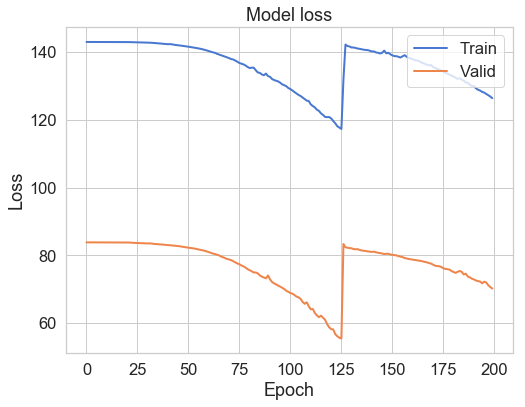

In [169]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check



Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

Expectation: the reconstruction error of 0 labeled data should be smaller than 1.

Caution: do not use this result for model evaluation. It may result into overfitting issues.

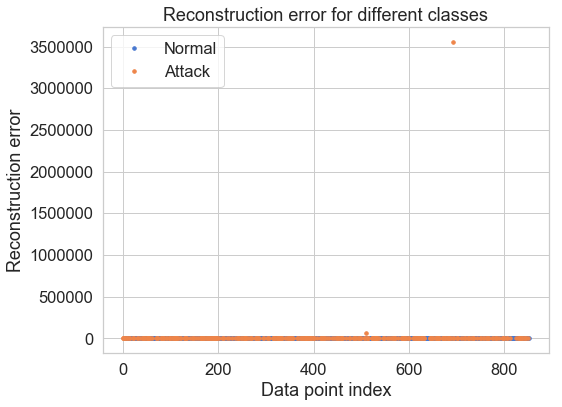

In [171]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the Autoencoder

Here we show how we can use an Autoencoder reconstruction error for the rare-event classification. We follow this concept: the autoencoder is expected to reconstruct a noif the reconstruction error is high, we will classify it as a sheet-break.

We will need to determine the threshold for this. Also, note that here we will be using the entire validation set containing both y = 0 or 1.

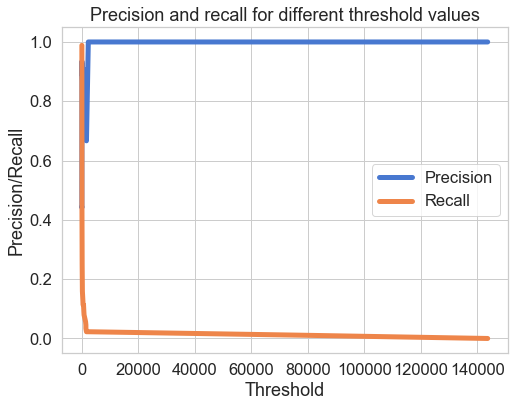

In [172]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

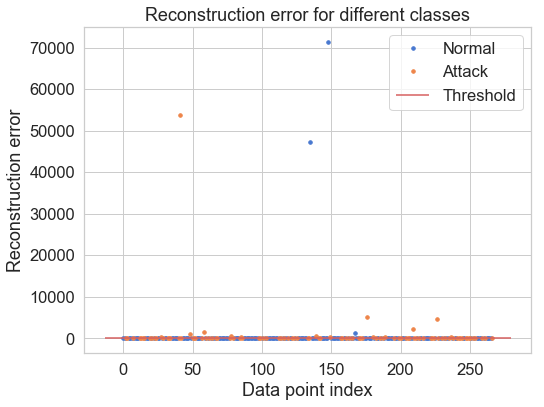

In [174]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

The orange and blue dot above the threshold line represents the True Positive and False Positive, respectively. As we can see, we have good number of false positives.

Let’s see the accuracy results.

In [175]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

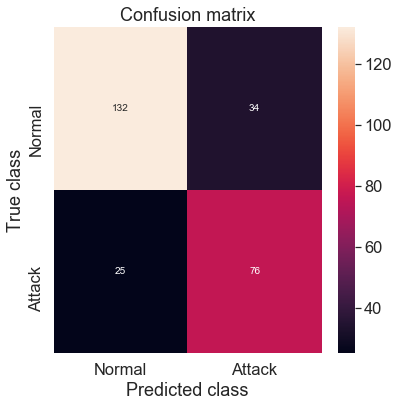

In [178]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

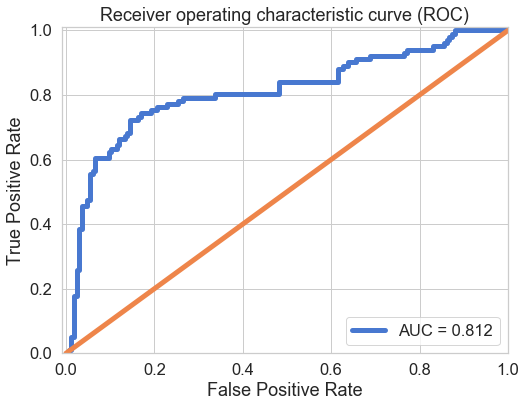

In [179]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusion

From the Confusion Matrix in Figure above, we could predict 76 out of 101 Attack instances. 

The primary reason is LSTM model has more parameters to estimate. It becomes important to use regularization with LSTMs.
